In [1]:
#https://github.com/silpara/simulators/blob/master/compartmental_models/SEIR%20Simulator%20in%20Python.ipynb
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.integrate import odeint
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
%matplotlib inline
plt.style.use('ggplot')

# Jupyter Specifics
from IPython.display import HTML
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [2]:
# Definicion de variables

# w - Parametro que mide el impacto de la guerra (afecta al numero de infectados y la disminucion en hospitalizacion)
# w esta entre cero y uno
w = 0.8
# beta - Es una funcion de w que representa impacto de la guerra y la tasa de contacto
def beta_w(w, beta_max = 0.4, k =10, A = 100):
    return beta_max / (1 + A * np.exp(-k * w))
# S - Poblacion susceptible
S = 86000000
#Q- Poblacion en cuarentena
Q = 0.0
# I - Poblacion Infectada
I = 2619
# H - Poblacion en hospitalizacion
H = 0
# R - Poblacion recuperada
R = 0
# D - Poblacion que murio
D = 1729
# N - Poblacion total
N = S + Q + I + H + R + D
# delta_i - tasa de hopitalización de los infecciosos
delta_i = 0.4
#delta_q - tasa de hospitalización de los de cuarentena
delta_q= 0.1
# gamma_i - tasa de recuperacion infecciosos (Tarda 18 dias en recuperarse y lo hace en 60% de los casos)
gamma_i = 0.25
# gamma_h - tasa de recuperacion de los hospitalizados
gamma_h = 0.25
# sigma_n - tasa de muerte de los infecciosos
sigma_i = 0.8
# sigma_h - tasa de muerte hospitalizados
sigma_h = 10^(-4)
# mu - tasa de muerte natural
mu = 0.0035
# rho - tasa de deshecho de cuerpos
rho = 0.5
# alpha_h - tasa de infeccion en hospitales 
alpha_h = 0.062
# alpha_m - tasa de infeccion de muertos 
alpha_m = 1.1
# q - tasa de cuarentena
q = 0.1#0.3
# v - tasa de vacunacion
v = 0.15
#  pi - Tasa de natalidad
pi = 120
# Dias - dias se simulacion
dias = 1000
# lambda
lam = 0.1

El modelo:

$\frac{dS}{dt} = \pi - (\lambda + v + \mu + q) S$

$\frac{dQ}{dt} = qS - (1-w) \delta_Q Q - \mu Q$

$\frac{dI}{dt} = \lambda S - ((1-w) \delta_I + \gamma_I + \sigma_I + \mu) I$

$\frac{dH}{dt} = (1-w) (\delta_Q Q + \delta_I I) - (\sigma_H + \gamma_H + \mu) H$

$\frac{dR}{dt} = v S + \gamma_I I + \gamma_H H - \mu R$

$\frac{dD}{dt} = \sigma_I I + \sigma_H H - \rho D$

con

$\lambda = \frac{\beta (I + \alpha_H H + \alpha_M D)}{N}$

In [3]:
### DEFINICIÓN DEL MODELO ###

def diff_eqs(INP, t, w, delta_i, delta_q, gamma_i, gamma_h, sigma_h, sigma_i, mu, lam, rho, alpha_h, alpha_m, q, v, pi):
    """
    Sistema de ecuaciones diferenciales.
    """
    # Cantidades actuales de cada compartimento
    S, Q, I, H, R, D = INP
    # Total de la poblacion
    N = S + Q + I + R + H + D
    
    beta = beta_w(w)               # Tasa de contacto efectivo de subpoblación asintomática a susceptible
    
    lam = beta * (I + alpha_h * H + alpha_m * D)/N
    
    dSdt = pi - (lam + v + mu + q) * S
    dQdt = q * S - (1-w) * delta_q * Q - mu * Q
    dIdt = lam * S - ((1-w) * delta_i + gamma_i + sigma_i + mu) * I
    dHdt = (1-w) * (delta_q * Q + delta_i * I) - (sigma_h + gamma_h + mu) * H
    dRdt = v * S + gamma_i * I + gamma_h * H - mu * R
    dDdt = sigma_i  * I + sigma_h * H - rho * D
    return [dSdt, dQdt, dIdt, dHdt, dRdt, dDdt]

In [4]:
def ode_solver(t, initial_conditions, params):
    S, Q, I, H, R, D = initial_conditions
    w, delta_i, delta_q, gamma_i, gamma_h, sigma_h, sigma_i, mu, lam, rho, alpha_h, alpha_m, q, v, pi = params
    res = odeint(diff_eqs, [S, Q, I, H, R, D], t, args=(w, delta_i, delta_q, gamma_i, gamma_h, sigma_h, sigma_i, mu, lam, rho, alpha_h, alpha_m, q, v, pi))
    return res

In [5]:
def main(S, Q, I, H, R, D, w, alpha_h, alpha_m, sigma_i, sigma_h, gamma_i, gamma_h, lam, rho, dias):
    initial_conditions = [S, Q, I, H, R, D]
    params = (w, delta_i, delta_q, gamma_i, gamma_h, sigma_h, sigma_i, mu, lam, rho, alpha_h, alpha_m, q, v, pi)
    periodo = np.arange(0, dias, 1)
    sol = ode_solver(periodo, initial_conditions, params)
    S, Q, I, H, R, D = sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3], sol[:, 4], sol[:, 5]
    
    # Separado
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=periodo, y=S, mode='lines+markers', name='Suceptibles'))
    fig.add_trace(go.Scatter(x=periodo, y=Q, mode='lines+markers', name='Cuarentena'))
    fig.add_trace(go.Scatter(x=periodo, y=I, mode='lines+markers', name='Infectados'))
    fig.add_trace(go.Scatter(x=periodo, y=R, mode='lines+markers', name='Recuperados'))
    fig.add_trace(go.Scatter(x=periodo, y=H, mode='lines+markers', name='Hospitalizados'))
    fig.add_trace(go.Scatter(x=periodo, y=D, mode='lines+markers', name='Muertos'))
    
    if dias <= 30:
        step = 1
    elif dias <= 90:
        step = 7
    else:
        step = 30
    
    # Junto
    fig.update_layout(title='Simulacion de un modelo de Ebola',
                       xaxis_title='Dia',
                       yaxis_title='Numero de personas',
                       title_x=0.5,
                      width=900, height=400
                     )
    fig.update_xaxes(tickangle=-90, tickformat = None, tickmode='array', tickvals=np.arange(0, dias + 1, step))
    if not os.path.exists("images"):
        os.mkdir("images")
    fig.write_image("images/ebola_simulation1.png")
    fig.show()
    
    # Junto
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=periodo, y = S + Q, mode='lines+markers', name='Suceptibles'))
    fig2.add_trace(go.Scatter(x=periodo, y = I + H + D, mode='lines+markers', name='Infectados'))
    fig2.add_trace(go.Scatter(x=periodo, y = R, mode='lines+markers', name='Recuperados'))
    fig2.add_trace(go.Scatter(x=periodo, y = N - S - Q - I - H - D - R, mode='lines+markers', name='Muertos'))
    
    if dias <= 30:
        step = 1
    elif dias <= 90:
        step = 7
    else:
        step = 30
    
    # Edit the layout
    fig2.update_layout(title='Simulacion de un modelo de Ebola',
                       xaxis_title='Dia',
                       yaxis_title='Numero de personas',
                       title_x=0.5,
                      width=900, height=400)
    fig2.update_xaxes(tickangle=-90, tickformat = None, tickmode='array', tickvals=np.arange(0, dias + 1, step))
    if not os.path.exists("images"):
        os.mkdir("images")
    fig2.write_image("images/ebola_simulation2.png")
    fig2.show()

In [6]:
interact(main,
         S = IntSlider(min=0, max=N, step=100, value=S, description='Susceptibles', style=style, layout=slider_layout),
         Q = IntSlider(min=0, max=N, step=100, value=Q, description='Cuarentena', style=style, layout=slider_layout),
         I = IntSlider(min=0, max=N, step=100, value=I, description='Infectados', style=style, layout=slider_layout),
         R = IntSlider(min=0, max=N, step=100, value=R, description='Recuperados', style=style, layout=slider_layout),
         H = IntSlider(min=0, max=N, step=100, value=H, description='Hospitalizados', style=style, layout=slider_layout),
         D = IntSlider(min=0, max=N, step=100, value=D, description='Muertos por bola', style=style, layout=slider_layout),
         w = FloatSlider(min=0, max=1, step=0.01, value=w, description='Nivel de guerra', style=style, layout=slider_layout),
         alpha_h = FloatSlider(min=0, max=2, step=0.01, value=alpha_h, description='alpha_h', style=style, layout=slider_layout),
         alpha_m = FloatSlider(min=0, max=2, step=0.01, value=alpha_m, description='alpha_m', style=style, layout=slider_layout),
         sigma_i = FloatSlider(min=0, max=2, step=0.01, value=sigma_i, description='sigma_i', style=style, layout=slider_layout),
         sigma_h = FloatSlider(min=0, max=2, step=0.01, value=sigma_h, description='sigma_h', style=style, layout=slider_layout),
         gamma_i = FloatSlider(min=0, max=2, step=0.01, value=gamma_i, description='gamma_i', style=style, layout=slider_layout),
         gamma_h = FloatSlider(min=0, max=2, step=0.01, value=gamma_h, description='gamma_h', style=style, layout=slider_layout),
         lam = FloatSlider(min=0, max=2, step=0.01, value=lam, description='lam', style=style, layout=slider_layout),
         rho = FloatSlider(min=0, max=2, step=0.01, value=rho, description='rho', style=style, layout=slider_layout),
         dias = IntSlider(min=0, max=100, step=7, value=dias, description='Días', style=style, layout=slider_layout)
        );

interactive(children=(IntSlider(value=86000000, description='Susceptibles', layout=Layout(width='99%'), max=86…

In [7]:
def beta_w(w, beta_max = 400, k =10, A = 100):
    return beta_max / (1 + A * np.exp(-k * w))

xx = np.arange(0, 1, 0.01)
yy = list(map(lambda x: beta_w(x), xx))

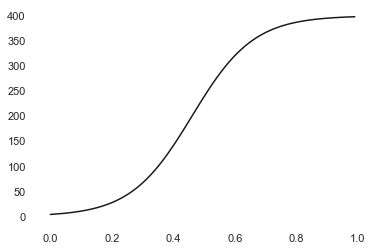

In [8]:
sns.set(rc={'axes.facecolor':'w', 'figure.facecolor':'w'})
sns.lineplot(xx, yy, color='k', )